# StyleMeUp - Fraud Detection in Online Retail 

### Data Science Model training, Pipeline, Deploy and serving

### In this notebook we will use the data enriched and prepared by our data engineers using the IPINFO dataset. 
##### We will follow following steps -

1. use snowpark python to connect with snowflake
2. get training dataset
3. feature visualization
4. Check feature importance
5. split training dataset into train and test
6. setup transformations
7. setup classifier
8. build ML Pipeline
9. train and test the model
10. check model accuracy
11. deploy model as Python UDF in snowflake

#### Finally, Use model deployed in Snowflake to score and predict data saved in snowflake


#### Let's get started by including snowpark python library. We will be using the latest 0.2.0 version for this demo


In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType

from matplotlib_venn import venn2
from config import snowfalke_conn_prop

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from snowflake.snowpark import version
print(f"Snowflake snowpark version is : {version.VERSION}")

Snowflake snowpark version is : (0, 2, 0, None)


#### Create a session to connect with snowflake

In [2]:
from snowflake.snowpark.session import Session
from config import snowfalke_conn_prop

session = Session.builder.configs(snowfalke_conn_prop).create()
print(session.sql('create schema if not exists frauddemo').collect())
print(session.sql('use schema frauddemo').collect())
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(status='FRAUDDEMO already exists, statement succeeded.')]
[Row(status='Statement executed successfully.')]
[Row(CURRENT_WAREHOUSE()='LAB_L_WH', CURRENT_DATABASE()='DEMO', CURRENT_SCHEMA()='FRAUDDEMO')]


In [3]:
train_dataset = session.table('enriched_data').sample(n = 20000)
df = train_dataset.toPandas()

## Data Exploration
### Masked IP feature visualization

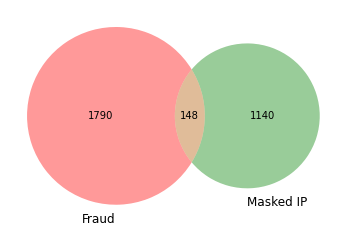

In [4]:
venn2(subsets = (len(df.loc[df['ISFRAUD'] == 1]), 
                 len(df.loc[df['IS_MASKED'] == 1]), 
                 len(df.loc[(df['ISFRAUD'] == 1) & (df['IS_MASKED'] == 1)])),
      set_labels = ('Fraud', 'Masked IP', 'Fraud & Masked IP'))
plt.show()

## Training fraud detection model

### Preparing training data

In [5]:
features = ['CITY', 'SHIPPING_ZIPCODE', 'SHIPPING_STATE', 'PAYMENT_NETWORK', 'PAYMENT_TYPE', 
            'IS_MASKED', 'AVG_PRICE_PER_ITEM', 'TOTAL_TRNX_AMOUNT', 'IP_TO_SHIPPING_DISTANCE']
encoded_features = ['CITY', 'SHIPPING_ZIPCODE', 'SHIPPING_STATE', 'PAYMENT_NETWORK', 'PAYMENT_TYPE','IS_MASKED']

num_feature_fill_na = ['IP_TO_SHIPPING_DISTANCE']


In [6]:
# get data into dataframe
data = session.table('enriched_data').sample(n = 10000)
df = pd.DataFrame(data.toPandas())

In [7]:
# setup pipeline

#transformations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

#Classifier
from sklearn.ensemble import RandomForestClassifier

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#Model Accuracy
from sklearn.metrics import balanced_accuracy_score

# split train and test
X = df[features]
y = df['ISFRAUD'] == True
weights = (y==0).sum()/(1.0 *  (y==1).sum())

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)


# Model Pipeline
ord_pipe = make_pipeline(
    FunctionTransformer(lambda x: x.astype(str)),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    )

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
    MinMaxScaler()
    )

clf = make_pipeline(RandomForestClassifier(random_state=0, n_jobs=-1))

model = make_pipeline(ord_pipe, num_pipe, clf)

# fit the model
model.fit(X_train, y_train)


Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function <lambda> at 0x7f14d1b73550>)),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1))])),
                ('pipeline-2',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('pipeline-3',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(n_jobs=-1,
                                                         random_state=0))]))])

#### Check Model balacne accuracy

In [8]:
#Check Accuracy of our model on test dataset
y_pred = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model testing completed.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model testing completed.
   - Model Balanced Accuracy: 100.00%


#### Check confusion matrix

In [9]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  230
False Positive(FP) =  0
True Negative(TN)  =  2270
False Negative(FN) =  0
Accuracy of the classification = 1.000


Text(0.5, 0, 'Feature Importance')

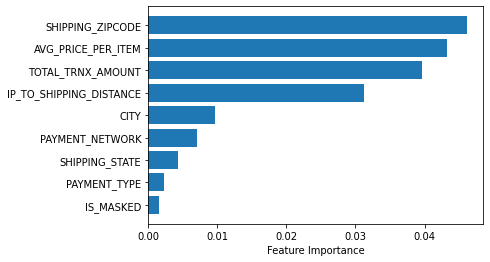

In [10]:
# Feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")


# Register model as UDF

In [11]:
@udf(name='predict_fraud_proba',is_permanent = True, stage_location = '@UDFSTAGE', replace=True)
def predict_fraud_proba(city: str, zipcode: str, state: str, network: str, payment_type: str, 
                  is_masked: bool, avg_amount: float, total_amount: float, ip_distance: float) -> float:
    rw = np.asarray([city, zipcode, state, network, payment_type, is_masked, avg_amount, total_amount, ip_distance])
    row_dict= dict(zip(features,rw)) 
    row = pd.DataFrame(row_dict, index=[0])
    return model.predict_proba(row)[:,1]

In [17]:
@udf(name='predict_fraud',is_permanent = True, stage_location = '@UDFSTAGE', replace=True)
def predict_fraud(city: str, zipcode: str, state: str, network: str, payment_type: str, 
                  is_masked: bool, avg_amount: float, total_amount: float, ip_distance: float) -> int:
    rw = np.asarray([city, zipcode, state, network, payment_type, is_masked, avg_amount, total_amount, ip_distance])
    row_dict= dict(zip(features,rw)) 
    row = pd.DataFrame(row_dict, index=[0])
    return model.predict(row)[0]

In [13]:
new_df = session.table(name = 'new_transaction_data')

# Predict fraud in new transactions

In [18]:
%%time
new_df.select(new_df.trnx_id,
              predict_fraud(new_df.city, new_df.shipping_zipcode, new_df.shipping_state,
                                new_df.payment_network, new_df.payment_type, new_df.is_masked, 
                                new_df.avg_price_per_item, new_df.total_trnx_amount,
                                new_df.ip_to_shipping_distance).alias('fraud_flag')) \
      .write.mode('overwrite').saveAsTable('fraud_detection')

CPU times: user 34.4 ms, sys: 28.4 ms, total: 62.8 ms
Wall time: 4min


In [22]:
session.table('fraud_detection').sample(n=10).toPandas()

,TRNX_ID,FRAUD_FLAG
0,GIYBR7EUBD,0
1,HY81GKZBQF,1
2,GAP7ONR9MB,0
3,BVEBF1JEGH,0
4,YSV96NWUUT,0
5,3RJHX8BPVX,0
6,U0GD06SEKT,0
7,1DGKDEBZSS,0
8,N36EZ9BXP6,0
9,YHIHNL9KWU,0


#### This demo showcase how Data Engineering and Data Science teams at StyleMeUp can use familiar programming concepts and APIs, and a rich ecosystem of open source packages provided by Snowpark for Python to collaborate and build this solution.

#### Snowflake marketplace and data exchange offerings quickly let you test and build your models using 1st, 2nd and 3rd party data sets for better accuracy and testing. Without worrying about the logisticts of ingesting, transforming and loading data in your own database

#### Some great features in this demo are -

1. Using Snowflake native GEOGRAPHY datatypes and ST_DISTANCE geography functions to calculate ip_to_shipping distance. (No need for GeoPandas)
2. Load data using pandas data frame (new functionality in Snowpark Python API)
3. Create and deploy UDF in snowflake without pickle
4. Using snowflake marketplace to quickly use 3rd party datasets without any dataengineering
5. Using scikit learn, pandas, NumPy 

In [16]:
#!pip list

Package                       Version
----------------------------- -------------------
alembic                       1.6.5
altair                        4.1.0
anyio                         3.1.0
appdirs                       1.4.4
argon2-cffi                   20.1.0
asn1crypto                    1.4.0
async-generator               1.10
attrs                         21.2.0
azure-common                  1.1.27
azure-core                    1.17.0
azure-storage-blob            12.8.1
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.9.3
bleach                        3.3.0
blinker                       1.4
bokeh                         2.3.2
boto3                         1.18.17
botocore                      1.21.17
Bottleneck                    1.3.2
brotlipy                      0.7.0
cached-property               1.5.2
certifi                       2021.5.30
certipy                       0.1.3
cf